# Расчет новых данных к 6 неделе
Глазунов А.В.

In [1]:
from google.colab import drive
drive.mount('/content/gdrive',force_remount=True)

Mounted at /content/gdrive


In [2]:
cd /content/gdrive/'My Drive'/Colab_Notebooks/ML_c6_TAXI

/content/gdrive/My Drive/Colab_Notebooks/ML_c6_TAXI


In [0]:
PATH_TO_DATA = 'data'

In [0]:
import warnings
warnings.filterwarnings('ignore')

import os
import pandas as pd
import numpy as np
from scipy import stats
from tqdm import tqdm_notebook
from matplotlib import pyplot as plt
import seaborn as sns
sns.set_style("darkgrid")
import gc
import statsmodels.api as sm

from itertools import product

In [0]:
zones = ['1075', '1076', '1077', '1125', '1126', '1127', '1128', '1129', '1130', '1131', '1132', '1172', '1173', '1174', '1175', \
         '1176', '1177', '1178', '1179', '1180', '1181', '1182', '1183', '1184', '1221', '1222', '1223', '1224', '1225', '1227',\
        '1228', '1229', '1230', '1231', '1232', '1233', '1234', '1235', '1272', '1273', '1274', '1278', '1279', '1280', '1281',\
        '1282', '1283', '1284', '1285', '1286', '1287', '1326', '1327', '1331', '1332', '1333', '1334', '1335', '1336', '1337', \
        '1338', '1339', '1376', '1377', '1378', '1380', '1382', '1383', '1384', '1385', '1386', '1387', '1388', '1389', '1390', \
        '1426', '1431', '1434', '1435', '1436', '1437', '1438', '1439', '1441', '1442', '1480', '1482', '1483', '1530', '1532', \
        '1533', '1580', '1630', '1684', '1733', '1734', '1783', '2068', '2069', '2118', '2119', '2168']


In [6]:
time_series_7_month = pd.read_csv(os.path.join(PATH_TO_DATA,'time_series_7_month.csv'),index_col=0)

initial_ts_zones = time_series_7_month[zones].copy()
initial_ts_zones.head()

,1075,1076,1077,1125,1126,1127,1128,1129,1130,1131,1132,1172,1173,1174,1175,1176,1177,1178,1179,1180,1181,1182,1183,1184,1221,1222,1223,1224,1225,1227,1228,1229,1230,1231,1232,1233,1234,1235,1272,1273,...,1376,1377,1378,1380,1382,1383,1384,1385,1386,1387,1388,1389,1390,1426,1431,1434,1435,1436,1437,1438,1439,1441,1442,1480,1482,1483,1530,1532,1533,1580,1630,1684,1733,1734,1783,2068,2069,2118,2119,2168
2015-12-01 00:00:00,19,43,26,76,91,129,202,230,212,56,2,5,5,7,3,12,192,305,218,271,241,201,24,2,6,10,8,12,1,160,218,224,311,394,626,237,81,16,7,9,...,9,4,6,5,14,27,80,35,15,20,16,9,10,8,16,1,2,15,12,3,5,2,4,8,9,5,9,5,18,2,3,0,2,97,29,96,16,246,31,118
2015-12-01 01:00:00,16,22,12,29,71,84,89,118,177,18,1,3,5,3,0,16,116,157,106,131,180,137,26,0,6,1,6,8,4,98,156,124,178,185,378,127,47,17,2,9,...,12,5,1,6,7,20,49,26,9,10,15,6,7,4,11,1,4,15,8,3,5,1,8,6,9,3,7,7,12,1,7,0,0,2,0,17,4,104,5,75
2015-12-01 02:00:00,8,19,3,9,21,42,76,99,180,14,0,0,8,2,0,15,63,133,70,104,161,117,12,0,3,3,6,5,2,78,116,68,118,109,230,75,15,7,7,4,...,14,4,2,4,8,11,31,10,5,6,10,8,9,4,4,0,1,12,6,3,4,1,2,7,5,3,6,4,5,4,5,0,0,0,0,4,1,28,0,0
2015-12-01 03:00:00,3,12,5,7,17,33,45,93,136,12,0,0,3,2,0,7,39,90,48,50,39,78,13,0,1,1,3,5,0,29,73,60,76,100,154,53,12,8,2,1,...,13,2,2,2,5,13,30,15,7,4,0,2,7,2,4,0,1,6,11,4,2,1,0,2,3,4,7,6,6,1,7,0,0,0,0,0,0,50,0,0
2015-12-01 04:00:00,2,12,3,7,21,33,27,62,80,3,1,0,4,1,0,7,28,64,53,62,113,113,13,3,1,1,4,3,0,31,94,54,71,92,191,64,27,12,0,4,...,8,5,3,2,3,24,60,29,10,3,4,3,0,3,9,0,2,14,11,1,3,1,0,5,7,6,6,6,4,3,4,1,0,4,2,2,0,23,1,15


In [0]:
fe_names =['trip_distance','trip_duration','total_amount',
            'payment_type_1','payment_type_2','payment_type_rest',
            'passenger_count','VendorID==1','dropoff_count',
            'main_cluster_destination','broadway_cluster_destination',
            'airport_cluster_destination','far_cluster_destination']

raw_feats_tables = {}
for fe_name in fe_names:
  df = pd.read_csv(os.path.join(PATH_TO_DATA,f'{fe_name}_7_month.csv'),index_col=0) 
  raw_feats_tables[fe_name] = df[zones]  

In [8]:
raw_feats_tables['trip_duration']

,1075,1076,1077,1125,1126,1127,1128,1129,1130,1131,1132,1172,1173,1174,1175,1176,1177,1178,1179,1180,1181,1182,1183,1184,1221,1222,1223,1224,1225,1227,1228,1229,1230,1231,1232,1233,1234,1235,1272,1273,...,1376,1377,1378,1380,1382,1383,1384,1385,1386,1387,1388,1389,1390,1426,1431,1434,1435,1436,1437,1438,1439,1441,1442,1480,1482,1483,1530,1532,1533,1580,1630,1684,1733,1734,1783,2068,2069,2118,2119,2168
2015-12-01 00:00:00,260.066667,650.166667,280.333333,1036.150000,2754.516667,1703.100000,4016.033333,4206.916667,3874.416667,754.283333,28.050000,36.650000,62.350000,76.850000,34.466667,127.566667,2204.766667,3493.916667,2231.933333,4457.733333,5586.716667,2035.650000,222.083333,17.016667,52.783333,107.900000,108.483333,150.300000,15.016667,1816.016667,2577.866667,3831.883333,3338.366667,5383.850000,10644.400000,2399.700000,723.750000,167.233333,74.350000,86.433333,...,81.966667,32.066667,74.316667,74.383333,165.750000,263.683333,715.066667,1721.316667,126.783333,158.800000,135.583333,93.383333,110.233333,85.816667,135.400000,6.466667,8.333333,122.166667,81.466667,32.833333,56.600000,17.533333,35.750000,67.366667,64.100000,48.550000,77.333333,31.866667,115.250000,13.650000,34.866667,0.000000,52.000000,1734.883333,574.000000,2862.116667,432.633333,7244.700000,878.500000,4782.016667
2015-12-01 01:00:00,243.300000,358.883333,174.733333,473.600000,947.050000,1008.783333,1058.000000,1446.516667,2037.383333,214.966667,11.333333,47.383333,65.566667,34.200000,0.000000,188.733333,1352.533333,1716.766667,1178.966667,3175.366667,2388.333333,1527.583333,286.850000,0.000000,67.683333,8.783333,66.000000,53.783333,64.366667,1177.250000,1923.366667,1366.650000,1693.683333,4703.800000,3800.866667,1427.300000,469.983333,207.216667,39.750000,129.566667,...,114.016667,33.733333,35.300000,62.950000,82.350000,143.550000,427.883333,192.133333,62.300000,71.850000,93.416667,46.983333,59.283333,40.150000,96.466667,0.600000,59.916667,134.383333,51.150000,19.650000,61.833333,14.116667,72.900000,30.483333,93.300000,17.083333,48.800000,62.283333,159.216667,2.450000,58.633333,0.000000,0.000000,30.216667,0.000000,433.433333,112.983333,2732.716667,128.483333,1859.833333
2015-12-01 02:00:00,142.366667,260.450000,49.283333,133.950000,371.666667,591.750000,915.250000,1266.433333,2205.400000,145.000000,0.000000,0.000000,51.033333,18.783333,0.000000,156.566667,670.950000,1552.916667,861.683333,1358.633333,2096.016667,1386.216667,115.016667,0.000000,44.100000,35.500000,76.966667,46.300000,46.283333,886.650000,1383.433333,2177.250000,2656.933333,1339.716667,3853.250000,2073.516667,139.666667,64.583333,85.516667,50.066667,...,1564.533333,67.033333,11.733333,37.900000,91.650000,85.066667,288.233333,72.650000,40.750000,87.333333,61.466667,46.950000,120.316667,27.750000,37.883333,0.000000,2.033333,68.283333,37.133333,16.066667,28.050000,35.600000,12.250000,79.666667,38.933333,42.100000,57.016667,28.816667,14.833333,73.916667,40.600000,0.000000,0.000000,0.000000,0.000000,75.050000,30.600000,696.750000,0.000000,0.000000
2015-12-01 03:00:00,59.533333,177.916667,141.500000,99.450000,220.700000,1692.866667,623.966667,1205.166667,1512.800000,77.566667,0.000000,0.000000,37.000000,29.200000,0.000000,74.650000,410.600000,1187.466667,519.366667,540.666667,547.916667,1125.250000,147.133333,0.000000,6.250000,4.383333,41.066667,48.966667,0.000000,1710.966667,844.916667,792.716667,3603.250000,1030.816667,3218.550000,593.833333,141.733333,81.750000,41.533333,25.750000,...,125.266667,29.983333,30.466667,18.133333,70.316667,145.933333,304.016667,126.383333,49.300000,35.050000,0.000000,15.583333,82.833333,40.850000,40.583333,0.000000,11.150000,57.000000,72.016667,18.866667,25.483333,12.466667,0.000000,23.016667,34.366667,29.100000,81.950000,45.616667,52.533333,4.933333,62.700000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1360.266667,0.000000,0.000000
2015-12-01 04:00:00,52.633333,258.250000,40.333333,114.350000,292.266667,402.000000,387.666667,2269.450000,1056.750000,24.583333,7.

In [0]:
fe_props = ['payment_type_1','payment_type_2','payment_type_rest',
            'VendorID==1','main_cluster_destination','broadway_cluster_destination',
            'airport_cluster_destination','far_cluster_destination']
fe_mean = ['trip_distance','trip_duration','total_amount']
fe_sum  = ['dropoff_count','passenger_count']

In [10]:
raw_feats_columns = []
for feat_name in tqdm_notebook(raw_feats_tables):

  raw_feat_table = raw_feats_tables[feat_name]

  indices = initial_ts_zones.index

  feat_zone_list = []
  for zone in tqdm_notebook(raw_feat_table.columns):

    if feat_name in fe_props:
            
      zone_ts_stats = raw_feat_table[[zone]].loc[indices].rolling(24).sum()
      initial_ts_stats = initial_ts_zones[[zone]].rolling(24).sum()

      zone_ts_stats[f'{feat_name}_prop_24'] = zone_ts_stats / initial_ts_stats  

      feat_zone_list.append(zone_ts_stats[[f'{feat_name}_prop_24']].copy())
    
    elif feat_name in fe_mean:
      zone_ts_stats = raw_feat_table[[zone]].loc[indices].rolling(24).mean()
      zone_ts_stats.columns = [f'{feat_name}_mean_24']     

      feat_zone_list.append(zone_ts_stats.copy())

    else:
      zone_ts_stats = raw_feat_table[[zone]].loc[indices].rolling(10).sum()
      zone_ts_stats.columns = [f'{feat_name}_sum_10']     

      feat_zone_list.append(zone_ts_stats.copy())

  raw_feat_column = pd.concat(feat_zone_list,axis = 0)
  raw_feats_columns.append(raw_feat_column)

raw_feats_df = pd.concat(raw_feats_columns,axis = 1).fillna(0)



In [11]:
raw_feats_df.iloc[22:30]

,trip_distance_mean_24,trip_duration_mean_24,total_amount_mean_24,payment_type_1_prop_24,payment_type_2_prop_24,payment_type_rest_prop_24,passenger_count_sum_10,VendorID==1_prop_24,dropoff_count_sum_10,main_cluster_destination_prop_24,broadway_cluster_destination_prop_24,airport_cluster_destination_prop_24,far_cluster_destination_prop_24
2015-12-01 22:00:00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1374.0,0.000000,648.0,0.000000,0.000000,0.000000,0.000000
2015-12-01 23:00:00,263.970417,1348.031250,1288.614167,0.694845,0.301718,0.003436,1314.0,0.458419,620.0,0.285223,0.171134,0.022680,0.030241
2015-12-02 00:00:00,267.007083,1361.808333,1302.070000,0.697754,0.298843,0.003404,1192.0,0.458135,572.0,0.281824,0.170865,0.022464,0.031314
2015-12-02 01:00:00,268.937083,1366.963194,1310.576667,0.703125,0.294158,0.002717,1048.0,0.459918,528.0,0.281929,0.170516,0.022418,0.031929
2015-12-02 02:00:00,269.744583,1367.440278,1314.065417,0.703327,0.293958,0.002716,962.0,0.458248,505.0,0.283775,0.170401,0.022403,0.031908
2015-12-02 03:00:00,270.654167,1368.803472,1317.469583,0.703252,0.294038,0.002710,858.0,0.456640,469.0,0.282520,0.170054,0.023035,0.031843
2015-12-02 04:00:00,271.683333,1370.221528,1320.670000,0.702703,0.294595,0.002703,761.0,0.457432,432.0,0.282432,0.170270,0.023649,0.031081
2015-12-02 05:00:00,270.307083,1367.488194,1314.280833,0.702300,0.294993,0.002706,618.0,0.458051,382.0,0.282138,0.171177,0.023004,0.031123


In [12]:
raw_feats_df.describe()

,trip_distance_mean_24,trip_duration_mean_24,total_amount_mean_24,payment_type_1_prop_24,payment_type_2_prop_24,payment_type_rest_prop_24,passenger_count_sum_10,VendorID==1_prop_24,dropoff_count_sum_10,main_cluster_destination_prop_24,broadway_cluster_destination_prop_24,airport_cluster_destination_prop_24,far_cluster_destination_prop_24
count,521424.000000,521424.000000,521424.000000,521424.000000,521424.000000,521424.000000,521424.000000,521424.000000,521424.000000,521424.000000,521424.000000,521424.000000,521424.000000
mean,441.966520,2401.011460,2395.550741,0.618274,0.370977,0.006187,2502.404755,0.461219,1419.019627,0.221382,0.032689,0.022674,0.090311
std,583.520988,3262.861416,3178.402711,0.109188,0.102400,0.006209,3758.477424,0.053275,2012.927157,0.136095,0.037528,0.023630,0.093240
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,34.645104,164.526910,173.862292,0.564935,0.305263,0.003059,164.000000,0.445312,187.000000,0.101449,0.007856,0.011471,0.020089
50%,117.892917,600.156250,597.322917,0.637681,0.356055,0.004444,584.000000,0.464563,483.000000,0.211919,0.019417,0.017881,0.042699
75%,706.696042,3760.191319,3826.718333,0.688312,0.425287,0.007843,3503.250000,0.481038,1850.000000,0.325058,0.040346,0.027945,0.165375
max,3361.779167,18898.593750,19916.728333,1.000000,1.000000,1.000000,29869.000000,1.000000,17909.000000,1.000000,0.500000,1.000000,1.000000


In [13]:
prediction_reg_7m = pd.read_csv(os.path.join(PATH_TO_DATA,'prediction_reg_7m.csv'),index_col=0)
prediction_reg_7m.head()

,1_hours_forecast,2_hours_forecast,3_hours_forecast,4_hours_forecast,5_hours_forecast,6_hours_forecast
0,9.446603,53.461533,62.725964,50.953915,67.012375,59.694588
1,7.852633,54.901604,64.393750,59.313503,68.659134,62.557373
2,4.299701,59.902157,63.465088,66.673035,66.004620,58.885280
3,3.014358,60.974880,68.454480,67.108380,64.249344,55.507286
4,11.664944,65.228720,73.569430,68.153520,63.840843,56.445190


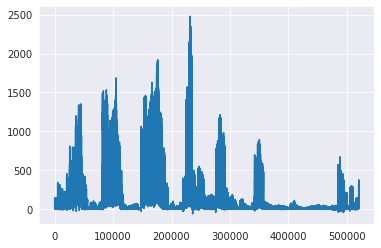

In [14]:
prediction_reg_7m['6_hours_forecast'].plot()

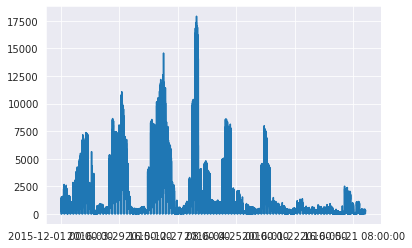

In [15]:
raw_feats_df.dropoff_count_sum_10.plot()

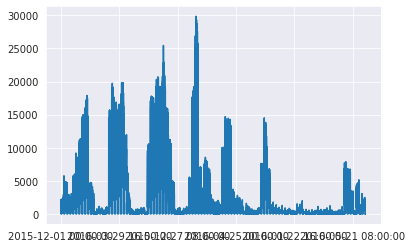

In [16]:
raw_feats_df.passenger_count_sum_10.plot()

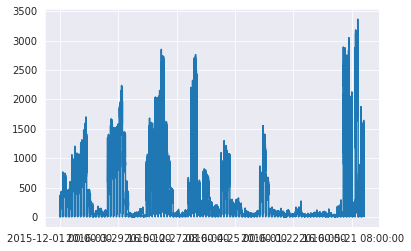

In [17]:
raw_feats_df.trip_distance_mean_24.plot()

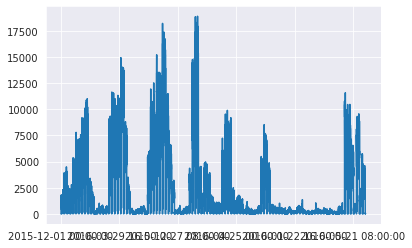

In [18]:
raw_feats_df.trip_duration_mean_24.plot()


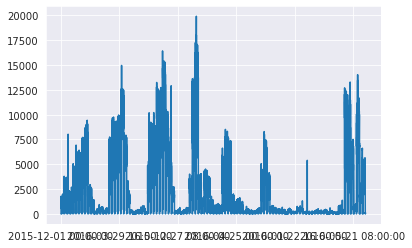

In [19]:
raw_feats_df.total_amount_mean_24.plot()

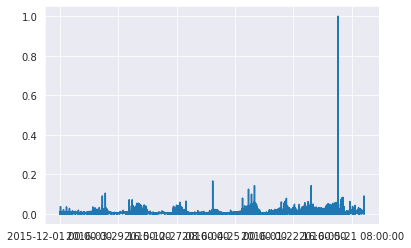

In [20]:
raw_feats_df.payment_type_rest_prop_24.plot()

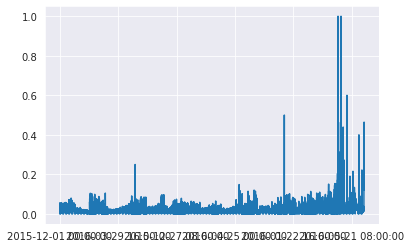

In [21]:
raw_feats_df.airport_cluster_destination_prop_24.plot()

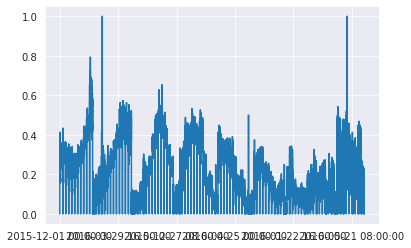

In [22]:
raw_feats_df.main_cluster_destination_prop_24.plot()

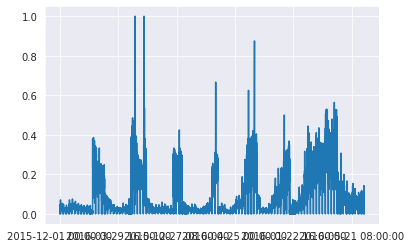

In [23]:
raw_feats_df.far_cluster_destination_prop_24.plot()


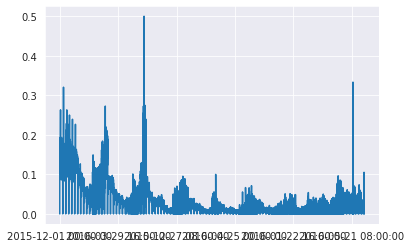

In [24]:
raw_feats_df.broadway_cluster_destination_prop_24.plot()

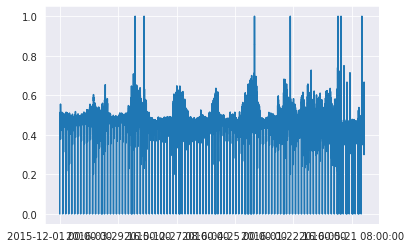

In [25]:
raw_feats_df['VendorID==1_prop_24'].plot()

In [26]:
added_areg_day_feats_list = []
added_areg_week_feats_list = []
for k in range(1,7):
  day_list = []
  week_list = []
  for zone in initial_ts_zones.columns:
    zone_ts = initial_ts_zones[[zone]].copy() 

    added_areg_k_fe_day =  zone_ts.shift(24-k).copy()
    added_areg_k_fe_day.columns = [f'added_areg_fe_day_{k}']
    added_areg_k_fe_week =  zone_ts.shift(168-k).copy()
    added_areg_k_fe_week.columns = [f'added_areg_fe_week_{k}']

    day_list.append(added_areg_k_fe_day)
    week_list.append(added_areg_k_fe_week)

  day_fe = pd.concat(day_list,axis=0)
  added_areg_day_feats_list.append(day_fe)

  week_fe = pd.concat(week_list,axis=0)
  added_areg_week_feats_list.append(week_fe)


added_areg_day_df = pd.concat(added_areg_day_feats_list,axis = 1).fillna(-1)
added_areg_week_df = pd.concat(added_areg_week_feats_list,axis=1).fillna(-1)
added_areg_day_df

,added_areg_fe_day_1,added_areg_fe_day_2,added_areg_fe_day_3,added_areg_fe_day_4,added_areg_fe_day_5,added_areg_fe_day_6
2015-12-01 00:00:00,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
2015-12-01 01:00:00,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
2015-12-01 02:00:00,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
2015-12-01 03:00:00,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
2015-12-01 04:00:00,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
...,...,...,...,...,...,...
2016-06-30 19:00:00,1.0,0.0,1.0,0.0,1.0,2.0
2016-06-30 20:00:00,0.0,1.0,0.0,1.0,2.0,0.0
2016-06-30 21:00:00,1.0,0.0,1.0,2.0,0.0,0.0
2016-06-30 22:00:00,0.0,1.0,2.0,0.0,0.0,0.0


In [27]:
added_areg_day_df.iloc[15:30]

,added_areg_fe_day_1,added_areg_fe_day_2,added_areg_fe_day_3,added_areg_fe_day_4,added_areg_fe_day_5,added_areg_fe_day_6
2015-12-01 15:00:00,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
2015-12-01 16:00:00,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
2015-12-01 17:00:00,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
2015-12-01 18:00:00,-1.0,-1.0,-1.0,-1.0,-1.0,19.0
2015-12-01 19:00:00,-1.0,-1.0,-1.0,-1.0,19.0,16.0
2015-12-01 20:00:00,-1.0,-1.0,-1.0,19.0,16.0,8.0
2015-12-01 21:00:00,-1.0,-1.0,19.0,16.0,8.0,3.0
2015-12-01 22:00:00,-1.0,19.0,16.0,8.0,3.0,2.0
2015-12-01 23:00:00,19.0,16.0,8.0,3.0,2.0,7.0
2015-12-02 00:00:00,16.0,8.0,3.0,2.0,7.0,20.0


In [28]:
added_areg_week_df.iloc[155:180]

,added_areg_fe_week_1,added_areg_fe_week_2,added_areg_fe_week_3,added_areg_fe_week_4,added_areg_fe_week_5,added_areg_fe_week_6
2015-12-07 11:00:00,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
2015-12-07 12:00:00,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
2015-12-07 13:00:00,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
2015-12-07 14:00:00,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
2015-12-07 15:00:00,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
2015-12-07 16:00:00,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
2015-12-07 17:00:00,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
2015-12-07 18:00:00,-1.0,-1.0,-1.0,-1.0,-1.0,19.0
2015-12-07 19:00:00,-1.0,-1.0,-1.0,-1.0,19.0,16.0
2015-12-07 20:00:00,-1.0,-1.0,-1.0,19.0,16.0,8.0


In [29]:
prop_seasonal_trend_zones_list = []

for zone in initial_ts_zones.columns:
  zone_ts = initial_ts_zones[[zone]].copy()
  zone_ts.index = pd.to_datetime(zone_ts.index) 
   
  stl_result = sm.tsa.seasonal_decompose(zone_ts)  
  trend = stl_result.trend.fillna(stl_result.trend.mean()) 
  seasonal = stl_result.seasonal

  prop_seasonal_trend = pd.DataFrame(abs(seasonal/trend))
  prop_seasonal_trend.columns = ['prop_seasonal_trend_stl']
  
  prop_seasonal_trend.at[prop_seasonal_trend[prop_seasonal_trend.prop_seasonal_trend_stl > 3].index,'prop_seasonal_trend_stl']=3
  
  prop_seasonal_trend_zones_list.append(prop_seasonal_trend)

prop_seasonal_trend_fe = pd.concat(prop_seasonal_trend_zones_list,axis=0)
prop_seasonal_trend_fe

,prop_seasonal_trend_stl
2015-12-01 00:00:00,0.352865
2015-12-01 01:00:00,0.623071
2015-12-01 02:00:00,0.797509
2015-12-01 03:00:00,0.878254
2015-12-01 04:00:00,0.891039
...,...
2016-06-30 19:00:00,0.444858
2016-06-30 20:00:00,0.600798
2016-06-30 21:00:00,0.659355
2016-06-30 22:00:00,0.711324


In [0]:
prop_seasonal_trend_fe.index = added_areg_week_df.index

In [31]:
added_areg_week_df.index

Index(['2015-12-01 00:00:00', '2015-12-01 01:00:00', '2015-12-01 02:00:00',
       '2015-12-01 03:00:00', '2015-12-01 04:00:00', '2015-12-01 05:00:00',
       '2015-12-01 06:00:00', '2015-12-01 07:00:00', '2015-12-01 08:00:00',
       '2015-12-01 09:00:00',
       ...
       '2016-06-30 14:00:00', '2016-06-30 15:00:00', '2016-06-30 16:00:00',
       '2016-06-30 17:00:00', '2016-06-30 18:00:00', '2016-06-30 19:00:00',
       '2016-06-30 20:00:00', '2016-06-30 21:00:00', '2016-06-30 22:00:00',
       '2016-06-30 23:00:00'],
      dtype='object', length=521424)

In [32]:
added_dataset = pd.concat([raw_feats_df,prop_seasonal_trend_fe,added_areg_day_df,added_areg_week_df],axis=1)
added_dataset['timestamp'] = pd.to_datetime(added_dataset.index)
added_dataset


,trip_distance_mean_24,trip_duration_mean_24,total_amount_mean_24,payment_type_1_prop_24,payment_type_2_prop_24,payment_type_rest_prop_24,passenger_count_sum_10,VendorID==1_prop_24,dropoff_count_sum_10,main_cluster_destination_prop_24,broadway_cluster_destination_prop_24,airport_cluster_destination_prop_24,far_cluster_destination_prop_24,prop_seasonal_trend_stl,added_areg_fe_day_1,added_areg_fe_day_2,added_areg_fe_day_3,added_areg_fe_day_4,added_areg_fe_day_5,added_areg_fe_day_6,added_areg_fe_week_1,added_areg_fe_week_2,added_areg_fe_week_3,added_areg_fe_week_4,added_areg_fe_week_5,added_areg_fe_week_6,timestamp
2015-12-01 00:00:00,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.352865,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,2015-12-01 00:00:00
2015-12-01 01:00:00,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.623071,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,2015-12-01 01:00:00
2015-12-01 02:00:00,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.797509,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,2015-12-01 02:00:00
2015-12-01 03:00:00,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.878254,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,2015-12-01 03:00:00
2015-12-01 04:00:00,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.891039,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,2015-12-01 04:00:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2016-06-30 19:00:00,13.002917,34.482639,62.396667,0.571429,0.428571,0.0,21.0,0.357143,288.0,0.0,0.0,0.214286,0.035714,0.444858,1.0,0.0,1.0,0.0,1.0,2.0,0.0,0.0,1.0,1.0,0.0,1.0,2016-06-30 19:00:00
2016-06-30 20:00:00,12.175417,32.559722,59.988333,0.555556,0.444444,0.0,20.0,0.370370,286.0,0.0,0.0,0.222222,0.037037,0.600798,0.0,1.0,0.0,1.0,2.0,0.0,0.0,1.0,1.0,0.0,1.0,6.0,2016-06-30 20:00:00
2016-06-30 21:00:00,12.271250,32.573611,62.902917,0.571429,0.428571,0.0,21.0,0.392857,273.0,0.0,0.0,0.250000,0.035714,0.659355,1.0,0.0,1.0,2.0,0.0,0.0,1.0,1.0,0.0,1.0,6.0,3.0,2016-06-30 21:00:00
2016-06-30 22:00:00,11.555417,30.960417,60.229167,0.555556,0.444444,0.0,19.0,0.407407,240.0,0.0,0.0,0.259259,0.037037,0.711324,0.0,1.0,2.0,0.0,0.0,0.0,1.0,0.0,1.0,6.0,3.0,1.0,2016-06-30 22:00:00


In [33]:
added_dataset_res = added_dataset[added_dataset['timestamp'] <= pd.to_datetime('2016-06-30 17:00:00')].copy()
added_dataset_res.index = list(range(added_dataset_res.shape[0]))
added_dataset_res

,trip_distance_mean_24,trip_duration_mean_24,total_amount_mean_24,payment_type_1_prop_24,payment_type_2_prop_24,payment_type_rest_prop_24,passenger_count_sum_10,VendorID==1_prop_24,dropoff_count_sum_10,main_cluster_destination_prop_24,broadway_cluster_destination_prop_24,airport_cluster_destination_prop_24,far_cluster_destination_prop_24,prop_seasonal_trend_stl,added_areg_fe_day_1,added_areg_fe_day_2,added_areg_fe_day_3,added_areg_fe_day_4,added_areg_fe_day_5,added_areg_fe_day_6,added_areg_fe_week_1,added_areg_fe_week_2,added_areg_fe_week_3,added_areg_fe_week_4,added_areg_fe_week_5,added_areg_fe_week_6,timestamp
0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.352865,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,2015-12-01 00:00:00
1,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.623071,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,2015-12-01 01:00:00
2,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.797509,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,2015-12-01 02:00:00
3,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.878254,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,2015-12-01 03:00:00
4,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.891039,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,2015-12-01 04:00:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
520807,12.805417,33.038889,56.691667,0.548387,0.451613,0.0,22.0,0.451613,274.0,0.0,0.0,0.354839,0.032258,0.049772,3.0,2.0,0.0,2.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,2.0,2016-06-30 13:00:00
520808,12.326250,31.415278,54.625000,0.535714,0.464286,0.0,22.0,0.392857,271.0,0.0,0.0,0.285714,0.035714,0.188812,2.0,0.0,2.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,2.0,0.0,2016-06-30 14:00:00
520809,11.813750,30.000000,52.683333,0.538462,0.461538,0.0,17.0,0.346154,284.0,0.0,0.0,0.230769,0.038462,0.143621,0.0,2.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,2.0,0.0,0.0,2016-06-30 15:00:00
520810,11.849583,30.014583,58.951667,0.571429,0.428571,0.0,13.0,0.357143,295.0,0.0,0.0,0.285714,0.035714,0.200056,2.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,2.0,0.0,0.0,1.0,2016-06-30 16:00:00


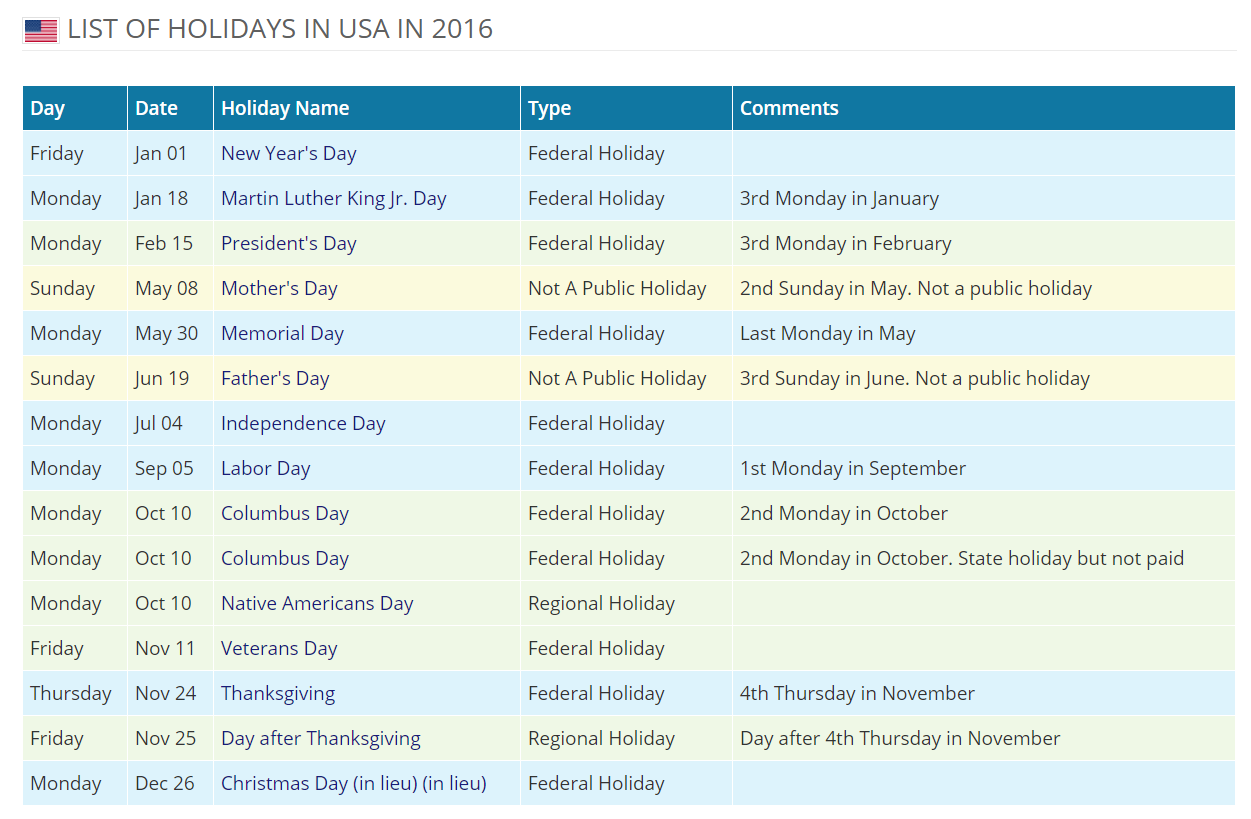

In [34]:
holidays_7m = ['2015-12-26','2016-01-01', '2016-01-18', '2016-02-15', '2016-05-08', '2016-05-30', '2016-06-19']
holidays_7m_dates = [pd.to_datetime(day).date() for day in holidays_7m]
holidays_7m_dates

[datetime.date(2015, 12, 26),
 datetime.date(2016, 1, 1),
 datetime.date(2016, 1, 18),
 datetime.date(2016, 2, 15),
 datetime.date(2016, 5, 8),
 datetime.date(2016, 5, 30),
 datetime.date(2016, 6, 19)]

In [35]:
added_dataset_res['is_holiday'] = added_dataset_res['timestamp'].apply(lambda x: int(x.date() in holidays_7m_dates))
added_dataset_res['is_weekend'] = added_dataset_res['timestamp'].apply(lambda x: int(x.weekday() in [5,6]))
added_dataset_res['is_night'] = added_dataset_res['timestamp'].apply(lambda x: int(x.hour in range(0,6)))
added_dataset_res['is_morning'] = added_dataset_res['timestamp'].apply(lambda x: int(x.hour in range(6,12)))
added_dataset_res['is_afternoon'] = added_dataset_res['timestamp'].apply(lambda x: int(x.hour in range(12,18)))
added_dataset_res['is_evening'] = added_dataset_res['timestamp'].apply(lambda x: int(x.hour in range(18,25)))
added_dataset_res

,trip_distance_mean_24,trip_duration_mean_24,total_amount_mean_24,payment_type_1_prop_24,payment_type_2_prop_24,payment_type_rest_prop_24,passenger_count_sum_10,VendorID==1_prop_24,dropoff_count_sum_10,main_cluster_destination_prop_24,broadway_cluster_destination_prop_24,airport_cluster_destination_prop_24,far_cluster_destination_prop_24,prop_seasonal_trend_stl,added_areg_fe_day_1,added_areg_fe_day_2,added_areg_fe_day_3,added_areg_fe_day_4,added_areg_fe_day_5,added_areg_fe_day_6,added_areg_fe_week_1,added_areg_fe_week_2,added_areg_fe_week_3,added_areg_fe_week_4,added_areg_fe_week_5,added_areg_fe_week_6,timestamp,is_holiday,is_weekend,is_night,is_morning,is_afternoon,is_evening
0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.352865,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,2015-12-01 00:00:00,0,0,1,0,0,0
1,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.623071,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,2015-12-01 01:00:00,0,0,1,0,0,0
2,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.797509,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,2015-12-01 02:00:00,0,0,1,0,0,0
3,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.878254,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,2015-12-01 03:00:00,0,0,1,0,0,0
4,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.891039,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,2015-12-01 04:00:00,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
520807,12.805417,33.038889,56.691667,0.548387,0.451613,0.0,22.0,0.451613,274.0,0.0,0.0,0.354839,0.032258,0.049772,3.0,2.0,0.0,2.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,2.0,2016-06-30 13:00:00,0,0,0,0,1,0
520808,12.326250,31.415278,54.625000,0.535714,0.464286,0.0,22.0,0.392857,271.0,0.0,0.0,0.285714,0.035714,0.188812,2.0,0.0,2.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,2.0,0.0,2016-06-30 14:00:00,0,0,0,0,1,0
520809,11.813750,30.000000,52.683333,0.538462,0.461538,0.0,17.0,0.346154,284.0,0.0,0.0,0.230769,0.038462,0.143621,0.0,2.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,2.0,0.0,0.0,2016-06-30 15:00:00,0,0,0,0,1,0
520810,11.849583,30.014583,58.951667,0.571429,0.428571,0.0,13.0,0.357143,295.0,0.0,0.0,0.285714,0.035714,0.200056,2.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,2.0,0.0,0.0,1.0,2016-06-30 16:00:00,0,0,0,0,1,0


In [36]:
datasets = {}
for number in range(1,7):
  dataset = pd.read_csv(os.path.join(PATH_TO_DATA ,f'dataset{number}.csv'),index_col=0)
  dataset['datetime'] = pd.to_datetime(dataset['datetime'])
  datasets[number] = dataset
datasets[1].head()

,hour_counter,year,month,month_name,day_of_year,day_of_month,day_of_week,day_name,day_hour,zone_id,datetime,history_12,history_24,history_168,history_720,ts,srmx_forecast,target
0,1,2015,12,December,335,1,1,Tuesday,0,1075,2015-12-01 00:00:00,1031.269231,1385.807692,10552.346154,43939.576923,19,56.797194,16.0
1,2,2015,12,December,335,1,1,Tuesday,1,1075,2015-12-01 01:00:00,967.538462,1382.846154,10543.153846,43900.000000,16,57.155572,8.0
2,3,2015,12,December,335,1,1,Tuesday,2,1075,2015-12-01 02:00:00,887.346154,1379.730769,10535.269231,43872.423077,8,57.516078,3.0
3,4,2015,12,December,335,1,1,Tuesday,3,1075,2015-12-01 03:00:00,792.615385,1379.153846,10531.961538,43854.961538,3,57.879168,2.0
4,5,2015,12,December,335,1,1,Tuesday,4,1075,2015-12-01 04:00:00,699.884615,1379.884615,10532.576923,43844.884615,2,58.244975,7.0


In [0]:
added_dataset_res['zone_id'] = datasets[1].zone_id.values.astype(int)

In [0]:
cluster_center = [1181,1231,1281,1282,1232,1230,1182,1233,1180]
 
cluster_bw = [1126,1127,1076]  
  
cluster_ap = [1684,1734,1733,1783,2069,2119,2068,2118,2168]
    
cluster_os = [1441,1442,1390,1439,1533,1483,1482,1532,1380,1480,1530,1580,\
                 1630,1426,1376,1377,1378,1272,1221,1273,1274,1175,1225,1222,1172] 

In [39]:
added_dataset_res['is_center'] = added_dataset_res['zone_id'].apply(lambda x: int(int(x) in cluster_center))
added_dataset_res['is_broadway'] = added_dataset_res['zone_id'].apply(lambda x: int(int(x) in cluster_bw))
added_dataset_res['is_airport'] = added_dataset_res['zone_id'].apply(lambda x: int(int(x) in cluster_ap))
added_dataset_res

,trip_distance_mean_24,trip_duration_mean_24,total_amount_mean_24,payment_type_1_prop_24,payment_type_2_prop_24,payment_type_rest_prop_24,passenger_count_sum_10,VendorID==1_prop_24,dropoff_count_sum_10,main_cluster_destination_prop_24,broadway_cluster_destination_prop_24,airport_cluster_destination_prop_24,far_cluster_destination_prop_24,prop_seasonal_trend_stl,added_areg_fe_day_1,added_areg_fe_day_2,added_areg_fe_day_3,added_areg_fe_day_4,added_areg_fe_day_5,added_areg_fe_day_6,added_areg_fe_week_1,added_areg_fe_week_2,added_areg_fe_week_3,added_areg_fe_week_4,added_areg_fe_week_5,added_areg_fe_week_6,timestamp,is_holiday,is_weekend,is_night,is_morning,is_afternoon,is_evening,zone_id,is_center,is_broadway,is_airport
0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.352865,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,2015-12-01 00:00:00,0,0,1,0,0,0,1075,0,0,0
1,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.623071,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,2015-12-01 01:00:00,0,0,1,0,0,0,1075,0,0,0
2,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.797509,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,2015-12-01 02:00:00,0,0,1,0,0,0,1075,0,0,0
3,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.878254,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,2015-12-01 03:00:00,0,0,1,0,0,0,1075,0,0,0
4,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.891039,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,2015-12-01 04:00:00,0,0,1,0,0,0,1075,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
520807,12.805417,33.038889,56.691667,0.548387,0.451613,0.0,22.0,0.451613,274.0,0.0,0.0,0.354839,0.032258,0.049772,3.0,2.0,0.0,2.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,2.0,2016-06-30 13:00:00,0,0,0,0,1,0,2168,0,0,1
520808,12.326250,31.415278,54.625000,0.535714,0.464286,0.0,22.0,0.392857,271.0,0.0,0.0,0.285714,0.035714,0.188812,2.0,0.0,2.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,2.0,0.0,2016-06-30 14:00:00,0,0,0,0,1,0,2168,0,0,1
520809,11.813750,30.000000,52.683333,0.538462,0.461538,0.0,17.0,0.346154,284.0,0.0,0.0,0.230769,0.038462,0.143621,0.0,2.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,2.0,0.0,0.0,2016-06-30 15:00:00,0,0,0,0,1,0,2168,0,0,1
520810,11.849583,30.014583,58.951667,0.571429,0.428571,0.0,13.0,0.357143,295.0,0.0,0.0,0.285714,0.035714,0.200056,2.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,2.0,0.0,0.0,1.0,2016-06-30 16:00:00,0,0,0,0,1,0,2168,0,0,1


In [40]:
regions = pd.read_csv(os.path.join(PATH_TO_DATA,'regions.csv'),sep=';')
regions.head()

,region,west,east,south,north
0,1,-74.25559,-74.244478,40.496120,40.504508
1,2,-74.25559,-74.244478,40.504508,40.512896
2,3,-74.25559,-74.244478,40.512896,40.521285
3,4,-74.25559,-74.244478,40.521285,40.529673
4,5,-74.25559,-74.244478,40.529673,40.538061


In [41]:
regions['zone_center_product'] = (regions.west + regions.east)/2 * (regions.south + regions.north)/2
regions['zone_center_product'] = regions['zone_center_product'] - regions['zone_center_product'].mean()
regions.head()

,region,west,east,south,north,zone_center_product
0,1,-74.25559,-74.244478,40.496120,40.504508,4.177674
1,2,-74.25559,-74.244478,40.504508,40.512896,3.554850
2,3,-74.25559,-74.244478,40.512896,40.521285,2.932025
3,4,-74.25559,-74.244478,40.521285,40.529673,2.309201
4,5,-74.25559,-74.244478,40.529673,40.538061,1.686377


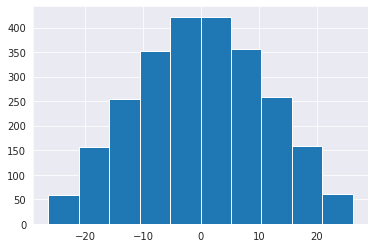

In [42]:
regions.zone_center_product.hist()

In [43]:
regions_vals = regions.values
added_dataset_res['zone_center_product'] = added_dataset_res['zone_id'].apply(lambda x: regions_vals[x-1,5])
added_dataset_res

,trip_distance_mean_24,trip_duration_mean_24,total_amount_mean_24,payment_type_1_prop_24,payment_type_2_prop_24,payment_type_rest_prop_24,passenger_count_sum_10,VendorID==1_prop_24,dropoff_count_sum_10,main_cluster_destination_prop_24,broadway_cluster_destination_prop_24,airport_cluster_destination_prop_24,far_cluster_destination_prop_24,prop_seasonal_trend_stl,added_areg_fe_day_1,added_areg_fe_day_2,added_areg_fe_day_3,added_areg_fe_day_4,added_areg_fe_day_5,added_areg_fe_day_6,added_areg_fe_week_1,added_areg_fe_week_2,added_areg_fe_week_3,added_areg_fe_week_4,added_areg_fe_week_5,added_areg_fe_week_6,timestamp,is_holiday,is_weekend,is_night,is_morning,is_afternoon,is_evening,zone_id,is_center,is_broadway,is_airport,zone_center_product
0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.352865,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,2015-12-01 00:00:00,0,0,1,0,0,0,1075,0,0,0,-1.272641
1,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.623071,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,2015-12-01 01:00:00,0,0,1,0,0,0,1075,0,0,0,-1.272641
2,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.797509,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,2015-12-01 02:00:00,0,0,1,0,0,0,1075,0,0,0,-1.272641
3,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.878254,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,2015-12-01 03:00:00,0,0,1,0,0,0,1075,0,0,0,-1.272641
4,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.891039,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,2015-12-01 04:00:00,0,0,1,0,0,0,1075,0,0,0,-1.272641
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
520807,12.805417,33.038889,56.691667,0.548387,0.451613,0.0,22.0,0.451613,274.0,0.0,0.0,0.354839,0.032258,0.049772,3.0,2.0,0.0,2.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,2.0,2016-06-30 13:00:00,0,0,0,0,1,0,2168,0,0,1,13.008799
520808,12.326250,31.415278,54.625000,0.535714,0.464286,0.0,22.0,0.392857,271.0,0.0,0.0,0.285714,0.035714,0.188812,2.0,0.0,2.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,2.0,0.0,2016-06-30 14:00:00,0,0,0,0,1,0,2168,0,0,1,13.008799
520809,11.813750,30.000000,52.683333,0.538462,0.461538,0.0,17.0,0.346154,284.0,0.0,0.0,0.230769,0.038462,0.143621,0.0,2.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,2.0,0.0,0.0,2016-06-30 15:00:00,0,0,0,0,1,0,2168,0,0,1,13.008799
520810,11.849583,30.014583,58.951667,0.571429,0.428571,0.0,13.0,0.357143,295.0,0.0,0.0,0.285714,0.035714,0.200056,2.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,2.0,0.0,0.0,1.0,2016-06-30 16:00:00,0,0,0,0,1,0,2168,0,0,1,13.008799


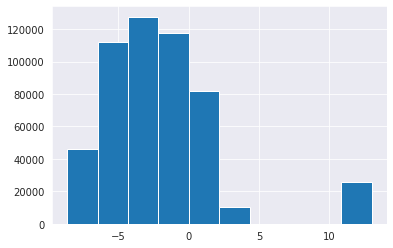

In [44]:
added_dataset_res['zone_center_product'].hist()

In [45]:
region_array = regions.region.values.reshape((50,50)).astype(str)
region_array

array([['1', '2', '3', ..., '48', '49', '50'],
       ['51', '52', '53', ..., '98', '99', '100'],
       ['101', '102', '103', ..., '148', '149', '150'],
       ...,
       ['2351', '2352', '2353', ..., '2398', '2399', '2400'],
       ['2401', '2402', '2403', ..., '2448', '2449', '2450'],
       ['2451', '2452', '2453', ..., '2498', '2499', '2500']],
      dtype='<U21')

In [46]:
np.array(zones)

array(['1075', '1076', '1077', '1125', '1126', '1127', '1128', '1129',
       '1130', '1131', '1132', '1172', '1173', '1174', '1175', '1176',
       '1177', '1178', '1179', '1180', '1181', '1182', '1183', '1184',
       '1221', '1222', '1223', '1224', '1225', '1227', '1228', '1229',
       '1230', '1231', '1232', '1233', '1234', '1235', '1272', '1273',
       '1274', '1278', '1279', '1280', '1281', '1282', '1283', '1284',
       '1285', '1286', '1287', '1326', '1327', '1331', '1332', '1333',
       '1334', '1335', '1336', '1337', '1338', '1339', '1376', '1377',
       '1378', '1380', '1382', '1383', '1384', '1385', '1386', '1387',
       '1388', '1389', '1390', '1426', '1431', '1434', '1435', '1436',
       '1437', '1438', '1439', '1441', '1442', '1480', '1482', '1483',
       '1530', '1532', '1533', '1580', '1630', '1684', '1733', '1734',
       '1783', '2068', '2069', '2118', '2119', '2168'], dtype='<U4')

In [47]:
neighbour_zones_dict = {}
for zone in zones:
  i,j = np.where( region_array==zone ) 
  zone_neibs = [region_array[i,j-1][0],region_array[i,j+1][0],region_array[i-1,j][0],region_array[i+1,j][0],
                region_array[i-1,j-1][0],region_array[i-1,j+1][0],region_array[i+1,j-1][0],region_array[i+1,j+1][0]]
  neighbour_zones_dict[zone] = zone_neibs
neighbour_zones_dict

{'1075': ['1074', '1076', '1025', '1125', '1024', '1026', '1124', '1126'],
 '1076': ['1075', '1077', '1026', '1126', '1025', '1027', '1125', '1127'],
 '1077': ['1076', '1078', '1027', '1127', '1026', '1028', '1126', '1128'],
 '1125': ['1124', '1126', '1075', '1175', '1074', '1076', '1174', '1176'],
 '1126': ['1125', '1127', '1076', '1176', '1075', '1077', '1175', '1177'],
 '1127': ['1126', '1128', '1077', '1177', '1076', '1078', '1176', '1178'],
 '1128': ['1127', '1129', '1078', '1178', '1077', '1079', '1177', '1179'],
 '1129': ['1128', '1130', '1079', '1179', '1078', '1080', '1178', '1180'],
 '1130': ['1129', '1131', '1080', '1180', '1079', '1081', '1179', '1181'],
 '1131': ['1130', '1132', '1081', '1181', '1080', '1082', '1180', '1182'],
 '1132': ['1131', '1133', '1082', '1182', '1081', '1083', '1181', '1183'],
 '1172': ['1171', '1173', '1122', '1222', '1121', '1123', '1221', '1223'],
 '1173': ['1172', '1174', '1123', '1223', '1122', '1124', '1222', '1224'],
 '1174': ['1173', '1175',

In [48]:
zones_list_sums = []
for zone in zones:
  zone_sums = time_series_7_month[neighbour_zones_dict[zone]].sum(axis=1)  
  zones_list_sums.append(pd.DataFrame(zone_sums,columns = ['zone_neib_sums']))

zone_neib_sums_fe = pd.concat(zones_list_sums,axis=0)
zone_neib_sums_fe['timestamp'] = pd.to_datetime(zone_neib_sums_fe.index)
zone_neib_sums_fe_res = zone_neib_sums_fe[zone_neib_sums_fe['timestamp'] <= pd.to_datetime('2016-06-30 17:00:00')][['zone_neib_sums']].copy()
zone_neib_sums_fe_res.index = list(range(zone_neib_sums_fe_res.shape[0]))
zone_neib_sums_fe_res

,zone_neib_sums
0,210
1,122
2,49
3,36
4,40
...,...
520807,244
520808,318
520809,267
520810,286


In [49]:
neighbour_zones_dict['1075']

['1074', '1076', '1025', '1125', '1024', '1026', '1124', '1126']

In [50]:
zone_neib_sums_fe_res_10 = zone_neib_sums_fe_res.rolling(10).sum().fillna(0)
zone_neib_sums_fe_res_10

,zone_neib_sums
0,0.0
1,0.0
2,0.0
3,0.0
4,0.0
...,...
520807,1426.0
520808,1726.0
520809,1901.0
520810,1963.0


In [51]:
zone_neib_sums_fe_res_10[8:15]

,zone_neib_sums
8,0.0
9,2303.0
10,2482.0
11,2811.0
12,3251.0
13,3694.0
14,4214.0


In [52]:
added_dataset_res['neibour_zones_count_10_h'] = zone_neib_sums_fe_res_10
added_dataset_res

,trip_distance_mean_24,trip_duration_mean_24,total_amount_mean_24,payment_type_1_prop_24,payment_type_2_prop_24,payment_type_rest_prop_24,passenger_count_sum_10,VendorID==1_prop_24,dropoff_count_sum_10,main_cluster_destination_prop_24,broadway_cluster_destination_prop_24,airport_cluster_destination_prop_24,far_cluster_destination_prop_24,prop_seasonal_trend_stl,added_areg_fe_day_1,added_areg_fe_day_2,added_areg_fe_day_3,added_areg_fe_day_4,added_areg_fe_day_5,added_areg_fe_day_6,added_areg_fe_week_1,added_areg_fe_week_2,added_areg_fe_week_3,added_areg_fe_week_4,added_areg_fe_week_5,added_areg_fe_week_6,timestamp,is_holiday,is_weekend,is_night,is_morning,is_afternoon,is_evening,zone_id,is_center,is_broadway,is_airport,zone_center_product,neibour_zones_count_10_h
0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.352865,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,2015-12-01 00:00:00,0,0,1,0,0,0,1075,0,0,0,-1.272641,0.0
1,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.623071,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,2015-12-01 01:00:00,0,0,1,0,0,0,1075,0,0,0,-1.272641,0.0
2,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.797509,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,2015-12-01 02:00:00,0,0,1,0,0,0,1075,0,0,0,-1.272641,0.0
3,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.878254,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,2015-12-01 03:00:00,0,0,1,0,0,0,1075,0,0,0,-1.272641,0.0
4,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.891039,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,2015-12-01 04:00:00,0,0,1,0,0,0,1075,0,0,0,-1.272641,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
520807,12.805417,33.038889,56.691667,0.548387,0.451613,0.0,22.0,0.451613,274.0,0.0,0.0,0.354839,0.032258,0.049772,3.0,2.0,0.0,2.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,2.0,2016-06-30 13:00:00,0,0,0,0,1,0,2168,0,0,1,13.008799,1426.0
520808,12.326250,31.415278,54.625000,0.535714,0.464286,0.0,22.0,0.392857,271.0,0.0,0.0,0.285714,0.035714,0.188812,2.0,0.0,2.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,2.0,0.0,2016-06-30 14:00:00,0,0,0,0,1,0,2168,0,0,1,13.008799,1726.0
520809,11.813750,30.000000,52.683333,0.538462,0.461538,0.0,17.0,0.346154,284.0,0.0,0.0,0.230769,0.038462,0.143621,0.0,2.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,2.0,0.0,0.0,2016-06-30 15:00:00,0,0,0,0,1,0,2168,0,0,1,13.008799,1901.0
520810,11.849583,30.014583,58.951667,0.571429,0.428571,0.0,13.0,0.357143,295.0,0.0,0.0,0.285714,0.035714,0.200056,2.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,2.0,0.0,0.0,1.0,2016-06-30 16:00:00,0,0,0,0,1,0,2168,0,0,1,13.008799,1963.0


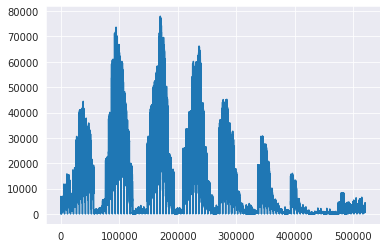

In [53]:
added_dataset_res['neibour_zones_count_10_h'].plot()

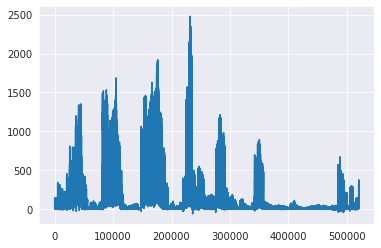

In [54]:
prediction_reg_7m['6_hours_forecast'].plot()

In [55]:
added_dataset_res['neibour_zones_count_1_h'] = zone_neib_sums_fe_res
added_dataset_res

,trip_distance_mean_24,trip_duration_mean_24,total_amount_mean_24,payment_type_1_prop_24,payment_type_2_prop_24,payment_type_rest_prop_24,passenger_count_sum_10,VendorID==1_prop_24,dropoff_count_sum_10,main_cluster_destination_prop_24,broadway_cluster_destination_prop_24,airport_cluster_destination_prop_24,far_cluster_destination_prop_24,prop_seasonal_trend_stl,added_areg_fe_day_1,added_areg_fe_day_2,added_areg_fe_day_3,added_areg_fe_day_4,added_areg_fe_day_5,added_areg_fe_day_6,added_areg_fe_week_1,added_areg_fe_week_2,added_areg_fe_week_3,added_areg_fe_week_4,added_areg_fe_week_5,added_areg_fe_week_6,timestamp,is_holiday,is_weekend,is_night,is_morning,is_afternoon,is_evening,zone_id,is_center,is_broadway,is_airport,zone_center_product,neibour_zones_count_10_h,neibour_zones_count_1_h
0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.352865,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,2015-12-01 00:00:00,0,0,1,0,0,0,1075,0,0,0,-1.272641,0.0,210
1,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.623071,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,2015-12-01 01:00:00,0,0,1,0,0,0,1075,0,0,0,-1.272641,0.0,122
2,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.797509,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,2015-12-01 02:00:00,0,0,1,0,0,0,1075,0,0,0,-1.272641,0.0,49
3,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.878254,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,2015-12-01 03:00:00,0,0,1,0,0,0,1075,0,0,0,-1.272641,0.0,36
4,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.891039,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,2015-12-01 04:00:00,0,0,1,0,0,0,1075,0,0,0,-1.272641,0.0,40
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
520807,12.805417,33.038889,56.691667,0.548387,0.451613,0.0,22.0,0.451613,274.0,0.0,0.0,0.354839,0.032258,0.049772,3.0,2.0,0.0,2.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,2.0,2016-06-30 13:00:00,0,0,0,0,1,0,2168,0,0,1,13.008799,1426.0,244
520808,12.326250,31.415278,54.625000,0.535714,0.464286,0.0,22.0,0.392857,271.0,0.0,0.0,0.285714,0.035714,0.188812,2.0,0.0,2.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,2.0,0.0,2016-06-30 14:00:00,0,0,0,0,1,0,2168,0,0,1,13.008799,1726.0,318
520809,11.813750,30.000000,52.683333,0.538462,0.461538,0.0,17.0,0.346154,284.0,0.0,0.0,0.230769,0.038462,0.143621,0.0,2.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,2.0,0.0,0.0,2016-06-30 15:00:00,0,0,0,0,1,0,2168,0,0,1,13.008799,1901.0,267
520810,11.849583,30.014583,58.951667,0.571429,0.428571,0.0,13.0,0.357143,295.0,0.0,0.0,0.285714,0.035714,0.200056,2.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,2.0,0.0,0.0,1.0,2016-06-30 16:00:00,0,0,0,0,1,0,2168,0,0,1,13.008799,1963.0,286


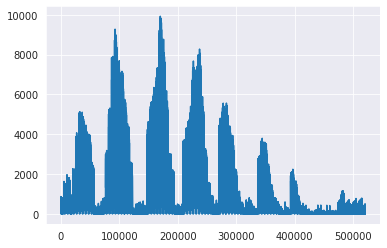

In [56]:
added_dataset_res['neibour_zones_count_1_h'].plot()

In [57]:
added_dataset_final = pd.concat([added_dataset_res,prediction_reg_7m],axis=1)
added_dataset_final 

,trip_distance_mean_24,trip_duration_mean_24,total_amount_mean_24,payment_type_1_prop_24,payment_type_2_prop_24,payment_type_rest_prop_24,passenger_count_sum_10,VendorID==1_prop_24,dropoff_count_sum_10,main_cluster_destination_prop_24,broadway_cluster_destination_prop_24,airport_cluster_destination_prop_24,far_cluster_destination_prop_24,prop_seasonal_trend_stl,added_areg_fe_day_1,added_areg_fe_day_2,added_areg_fe_day_3,added_areg_fe_day_4,added_areg_fe_day_5,added_areg_fe_day_6,added_areg_fe_week_1,added_areg_fe_week_2,added_areg_fe_week_3,added_areg_fe_week_4,added_areg_fe_week_5,added_areg_fe_week_6,timestamp,is_holiday,is_weekend,is_night,is_morning,is_afternoon,is_evening,zone_id,is_center,is_broadway,is_airport,zone_center_product,neibour_zones_count_10_h,neibour_zones_count_1_h,1_hours_forecast,2_hours_forecast,3_hours_forecast,4_hours_forecast,5_hours_forecast,6_hours_forecast
0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.352865,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,2015-12-01 00:00:00,0,0,1,0,0,0,1075,0,0,0,-1.272641,0.0,210,9.446603,53.461533,62.725964,50.953915,67.012375,59.694588
1,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.623071,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,2015-12-01 01:00:00,0,0,1,0,0,0,1075,0,0,0,-1.272641,0.0,122,7.852633,54.901604,64.393750,59.313503,68.659134,62.557373
2,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.797509,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,2015-12-01 02:00:00,0,0,1,0,0,0,1075,0,0,0,-1.272641,0.0,49,4.299701,59.902157,63.465088,66.673035,66.004620,58.885280
3,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.878254,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,2015-12-01 03:00:00,0,0,1,0,0,0,1075,0,0,0,-1.272641,0.0,36,3.014358,60.974880,68.454480,67.108380,64.249344,55.507286
4,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.891039,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,2015-12-01 04:00:00,0,0,1,0,0,0,1075,0,0,0,-1.272641,0.0,40,11.664944,65.228720,73.569430,68.153520,63.840843,56.445190
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
520807,12.805417,33.038889,56.691667,0.548387,0.451613,0.0,22.0,0.451613,274.0,0.0,0.0,0.354839,0.032258,0.049772,3.0,2.0,0.0,2.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,2.0,2016-06-30 13:00:00,0,0,0,0,1,0,2168,0,0,1,13.008799,1426.0,244,18.024553,4.196733,120.969580,109.817345,64.195310,242.774080
520808,12.326250,31.415278,54.625000,0.535714,0.464286,0.0,22.0,0.392857,271.0,0.0,0.0,0.285714,0.035714,0.188812,2.0,0.0,2.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,2.0,0.0,2016-06-30 14:00:00,0,0,0,0,1,0,2168,0,0,1,13.008799,1726.0,318,13.682662,50.272780,115.035000,100.352350,100.783950,257.700260
520809,11.813750,30.000000,52.683333,0.538462,0.461538,0.0,17.0,0.346154,284.0,0.0,0.0,0.230769,0.038462,0.143621,0.0,2.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,2.0,0.0,0.0,2016-06-30 15:00:00,0,0,0,0,1,0,2168,0,0,1,13.008799,1901.0,267,11.795953,28.722588,112.195220,124.830124,125.333970,250.547320
520810,11.849583,30.014583,58.951667,0.571429,0.428571,0.0,13.0,0.357143,295.0,0.0,0.0,0.285714,0.035714,0.200056,2.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,2.0,0.0,0.0,1.0,2016-06-30 16:00:00,0,0,0,0,1,0,2168,0,0,1,13.008799,1963.0,286,19.414177,26.127470,91.307430,131.136860,144.680040,248.624070


In [0]:
common_columns = ['trip_distance_mean_24',	'trip_duration_mean_24',	'total_amount_mean_24',	'payment_type_1_prop_24',
                  'payment_type_2_prop_24',	'payment_type_rest_prop_24',	'passenger_count_sum_10',	'VendorID==1_prop_24',
                  'dropoff_count_sum_10',	'main_cluster_destination_prop_24',	'broadway_cluster_destination_prop_24',
                  'airport_cluster_destination_prop_24',	'far_cluster_destination_prop_24',	'prop_seasonal_trend_stl',
                  'is_holiday',	'is_weekend',	'is_night',	'is_morning',	'is_afternoon',	'is_evening',	'is_center',
                  'is_broadway',	'is_airport',	'zone_center_product',	'neibour_zones_count_10_h',	'neibour_zones_count_1_h']

In [0]:
datasets_new = {}
for number in range(1,7):
  
  dataset_old = datasets[number].copy()

  cols_to_add = common_columns + [f'added_areg_fe_day_{number}',f'added_areg_fe_week_{number}',f'{number}_hours_forecast']
  df_to_add = added_dataset_final[cols_to_add].copy() 
  dataset_old.index = df_to_add.index
  dataset_new = pd.concat([dataset_old,df_to_add],axis=1)

  datasets_new[number] = dataset_new.copy() 

In [60]:
datasets_new[1]

,hour_counter,year,month,month_name,day_of_year,day_of_month,day_of_week,day_name,day_hour,zone_id,datetime,history_12,history_24,history_168,history_720,ts,srmx_forecast,target,trip_distance_mean_24,trip_duration_mean_24,total_amount_mean_24,payment_type_1_prop_24,payment_type_2_prop_24,payment_type_rest_prop_24,passenger_count_sum_10,VendorID==1_prop_24,dropoff_count_sum_10,main_cluster_destination_prop_24,broadway_cluster_destination_prop_24,airport_cluster_destination_prop_24,far_cluster_destination_prop_24,prop_seasonal_trend_stl,is_holiday,is_weekend,is_night,is_morning,is_afternoon,is_evening,is_center,is_broadway,is_airport,zone_center_product,neibour_zones_count_10_h,neibour_zones_count_1_h,added_areg_fe_day_1,added_areg_fe_week_1,1_hours_forecast
0,1,2015,12,December,335,1,1,Tuesday,0,1075,2015-12-01 00:00:00,1031.269231,1385.807692,10552.346154,43939.576923,19,56.797194,16.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.352865,0,0,1,0,0,0,0,0,0,-1.272641,0.0,210,-1.0,-1.0,9.446603
1,2,2015,12,December,335,1,1,Tuesday,1,1075,2015-12-01 01:00:00,967.538462,1382.846154,10543.153846,43900.000000,16,57.155572,8.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.623071,0,0,1,0,0,0,0,0,0,-1.272641,0.0,122,-1.0,-1.0,7.852633
2,3,2015,12,December,335,1,1,Tuesday,2,1075,2015-12-01 02:00:00,887.346154,1379.730769,10535.269231,43872.423077,8,57.516078,3.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.797509,0,0,1,0,0,0,0,0,0,-1.272641,0.0,49,-1.0,-1.0,4.299701
3,4,2015,12,December,335,1,1,Tuesday,3,1075,2015-12-01 03:00:00,792.615385,1379.153846,10531.961538,43854.961538,3,57.879168,2.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.878254,0,0,1,0,0,0,0,0,0,-1.272641,0.0,36,-1.0,-1.0,3.014358
4,5,2015,12,December,335,1,1,Tuesday,4,1075,2015-12-01 04:00:00,699.884615,1379.884615,10532.576923,43844.884615,2,58.244975,7.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.891039,0,0,1,0,0,0,0,0,0,-1.272641,0.0,40,-1.0,-1.0,11.664944
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
520807,5102,2016,6,June,182,30,3,Thursday,13,2168,2016-06-30 13:00:00,20.000000,32.000000,225.000000,22961.000000,1,103.811500,NaN,12.805417,33.038889,56.691667,0.548387,0.451613,0.0,22.0,0.451613,274.0,0.0,0.0,0.354839,0.032258,0.049772,0,0,0,0,1,0,0,0,1,13.008799,1426.0,244,3.0,0.0,18.024553
520808,5103,2016,6,June,182,30,3,Thursday,14,2168,2016-06-30 14:00:00,18.000000,31.000000,225.000000,22840.000000,0,91.161645,NaN,12.326250,31.415278,54.625000,0.535714,0.464286,0.0,22.0,0.392857,271.0,0.0,0.0,0.285714,0.035714,0.188812,0,0,0,0,1,0,0,0,1,13.008799,1726.0,318,2.0,0.0,13.682662
520809,5104,2016,6,June,182,30,3,Thursday,15,2168,2016-06-30 15:00:00,18.000000,28.000000,225.000000,22766.000000,0,128.456656,NaN,11.813750,30.000000,52.683333,0.538462,0.461538,0.0,17.0,0.346154,284.0,0.0,0.0,0.230769,0.038462,0.143621,0,0,0,0,1,0,0,0,1,13.008799,1901.0,267,0.0,0.0,11.795953
520810,5105,2016,6,June,182,30,3,Thursday,16,2168,2016-06-30 16:00:00,20.000000,28.000000,227.000000,22692.000000,2,110.476134,NaN,11.849583,30.014583,58.951667,0.571429,0.428571,0.0,13.0,0.357143,295.0,0.0,0.0,0.285714,0.035714,0.200056,0,0,0,0,1,0,0,0,1,13.008799,1963.0,286,2.0,0.0,19.414177


In [0]:
for number in range(1,7):
  datasets_new[number].to_csv(os.path.join(PATH_TO_DATA,f'dataset_6w_{number}.csv'))

In [0]:
datasets_new[6].to_csv(os.path.join(PATH_TO_DATA,f'dataset_6w_6.csv'))

In [63]:
datasets_new[6]

,hour_counter,year,month,month_name,day_of_year,day_of_month,day_of_week,day_name,day_hour,zone_id,datetime,history_12,history_24,history_168,history_720,ts,srmx_forecast,target,trip_distance_mean_24,trip_duration_mean_24,total_amount_mean_24,payment_type_1_prop_24,payment_type_2_prop_24,payment_type_rest_prop_24,passenger_count_sum_10,VendorID==1_prop_24,dropoff_count_sum_10,main_cluster_destination_prop_24,broadway_cluster_destination_prop_24,airport_cluster_destination_prop_24,far_cluster_destination_prop_24,prop_seasonal_trend_stl,is_holiday,is_weekend,is_night,is_morning,is_afternoon,is_evening,is_center,is_broadway,is_airport,zone_center_product,neibour_zones_count_10_h,neibour_zones_count_1_h,added_areg_fe_day_6,added_areg_fe_week_6,6_hours_forecast
0,1,2015,12,December,335,1,1,Tuesday,0,1075,2015-12-01 00:00:00,1031.269231,1385.807692,10552.346154,43939.576923,19,58.613734,20.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.352865,0,0,1,0,0,0,0,0,0,-1.272641,0.0,210,-1.0,-1.0,59.694588
1,2,2015,12,December,335,1,1,Tuesday,1,1075,2015-12-01 01:00:00,967.538462,1382.846154,10543.153846,43900.000000,16,58.985778,54.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.623071,0,0,1,0,0,0,0,0,0,-1.272641,0.0,122,-1.0,-1.0,62.557373
2,3,2015,12,December,335,1,1,Tuesday,2,1075,2015-12-01 02:00:00,887.346154,1379.730769,10535.269231,43872.423077,8,59.365592,94.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.797509,0,0,1,0,0,0,0,0,0,-1.272641,0.0,49,-1.0,-1.0,58.885280
3,4,2015,12,December,335,1,1,Tuesday,3,1075,2015-12-01 03:00:00,792.615385,1379.153846,10531.961538,43854.961538,3,59.750410,81.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.878254,0,0,1,0,0,0,0,0,0,-1.272641,0.0,36,-1.0,-1.0,55.507286
4,5,2015,12,December,335,1,1,Tuesday,4,1075,2015-12-01 04:00:00,699.884615,1379.884615,10532.576923,43844.884615,2,60.115345,56.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.891039,0,0,1,0,0,0,0,0,0,-1.272641,0.0,40,-1.0,-1.0,56.445190
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
520807,5102,2016,6,June,182,30,3,Thursday,13,2168,2016-06-30 13:00:00,20.000000,32.000000,225.000000,22961.000000,1,117.553181,NaN,12.805417,33.038889,56.691667,0.548387,0.451613,0.0,22.0,0.451613,274.0,0.0,0.0,0.354839,0.032258,0.049772,0,0,0,0,1,0,0,0,1,13.008799,1426.0,244,0.0,2.0,242.774080
520808,5103,2016,6,June,182,30,3,Thursday,14,2168,2016-06-30 14:00:00,18.000000,31.000000,225.000000,22840.000000,0,134.352453,NaN,12.326250,31.415278,54.625000,0.535714,0.464286,0.0,22.0,0.392857,271.0,0.0,0.0,0.285714,0.035714,0.188812,0,0,0,0,1,0,0,0,1,13.008799,1726.0,318,1.0,0.0,257.700260
520809,5104,2016,6,June,182,30,3,Thursday,15,2168,2016-06-30 15:00:00,18.000000,28.000000,225.000000,22766.000000,0,149.984286,NaN,11.813750,30.000000,52.683333,0.538462,0.461538,0.0,17.0,0.346154,284.0,0.0,0.0,0.230769,0.038462,0.143621,0,0,0,0,1,0,0,0,1,13.008799,1901.0,267,0.0,0.0,250.547320
520810,5105,2016,6,June,182,30,3,Thursday,16,2168,2016-06-30 16:00:00,20.000000,28.000000,227.000000,22692.000000,2,148.529189,NaN,11.849583,30.014583,58.951667,0.571429,0.428571,0.0,13.0,0.357143,295.0,0.0,0.0,0.285714,0.035714,0.200056,0,0,0,0,1,0,0,0,1,13.008799,1963.0,286,1.0,1.0,248.624070
